Check the running torch version

In [4]:
import torch
torch.__version__

'1.2.0'

In [5]:
import sys

assert sys.version_info >= (3, 6) # Python ≥3.6 required

# Download and explore iam dataset

In [6]:
%load_ext autoreload
%autoreload 2

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

import sys
sys.path.append('..')

import toml

from pathlib import Path
Path.ls = lambda x: list(x.iterdir())  # Source: https://github.com/fastai/fastai/blob/master/fastai/core.py#L236

from tqdm import tqdm

from PIL import Image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from src.datasets import Dataset

In [8]:
lines_detector_path = Dataset.processed_data_path()/"lines-segmentation"
lines_detector_images_path = lines_detector_path/"images"
lines_detector_masks_path = lines_detector_path/"masks"

lines_detector_images_path.mkdir(parents=True, exist_ok=True)
lines_detector_masks_path.mkdir(parents=True, exist_ok=True)

In [9]:
path = Dataset.raw_data_path()/"iam"

In [10]:
path.ls()

[PosixPath('/Users/mostafagazar/Work/notebooks/lines-segmentation-pytorch/data/raw/iam/.DS_Store'),
 PosixPath('/Users/mostafagazar/Work/notebooks/lines-segmentation-pytorch/data/raw/iam/readme.md'),
 PosixPath('/Users/mostafagazar/Work/notebooks/lines-segmentation-pytorch/data/raw/iam/metadata.toml')]

In [11]:
!cat {path}/metadata.toml

url = 'https://s3-us-west-2.amazonaws.com/fsdl-public-assets/iam/iamdb.zip'
filename = 'iamdb.zip'
sha256 = 'f3c9e87a88a313e557c6d3548ed8a2a1af2dc3c4a678c5f3fc6f972ba4a50c55'


## Download dataset

In [12]:
metadata = toml.load(path/"metadata.toml")
metadata

{'url': 'https://s3-us-west-2.amazonaws.com/fsdl-public-assets/iam/iamdb.zip',
 'filename': 'iamdb.zip',
 'sha256': 'f3c9e87a88a313e557c6d3548ed8a2a1af2dc3c4a678c5f3fc6f972ba4a50c55'}

In [22]:
Path(metadata["filename"]).stem

'iamdb'

In [23]:
cache_path = Dataset.cache_data_path()/"datasets"
cache_path.mkdir(parents=True, exist_ok=True)

data_path = cache_path/Path(metadata["filename"]).stem
if not data_path.exists():
    print(">> Download iam dataset")
    !wget -O {cache_path/metadata['filename']} {metadata['url']}
    print(">> Unzip it")
    !unzip {cache_path/metadata['filename']} -d {cache_path}
    print(">> Done")
else:
    print("Data already downloaded")

>> Download iam dataset
--2019-09-12 07:15:37--  https://s3-us-west-2.amazonaws.com/fsdl-public-assets/iam/iamdb.zip
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.225.40
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.225.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 614648402 (586M) [application/zip]
Saving to: ‘/Users/mostafagazar/Work/notebooks/lines-segmentation-pytorch/data/cache/datasets/iamdb.zip’

/Users/mostafagazar 100%[===================>] 586.17M  2.22MB/s    in 4m 39s  

2019-09-12 07:20:16 (2.10 MB/s) - ‘/Users/mostafagazar/Work/notebooks/lines-segmentation-pytorch/data/cache/datasets/iamdb.zip’ saved [614648402/614648402]

>> Unzip it
Archive:  /Users/mostafagazar/Work/notebooks/lines-segmentation-pytorch/data/cache/datasets/iamdb.zip
   creating: /Users/mostafagazar/Work/notebooks/lines-segmentation-pytorch/data/cache/datasets/iamdb/
   creating: /Users/mostafagazar/Work/notebooks

In [24]:
data_path.ls()

[PosixPath('/Users/mostafagazar/Work/notebooks/lines-segmentation-pytorch/data/cache/datasets/iamdb/ascii'),
 PosixPath('/Users/mostafagazar/Work/notebooks/lines-segmentation-pytorch/data/cache/datasets/iamdb/.DS_Store'),
 PosixPath('/Users/mostafagazar/Work/notebooks/lines-segmentation-pytorch/data/cache/datasets/iamdb/forms'),
 PosixPath('/Users/mostafagazar/Work/notebooks/lines-segmentation-pytorch/data/cache/datasets/iamdb/xml'),
 PosixPath('/Users/mostafagazar/Work/notebooks/lines-segmentation-pytorch/data/cache/datasets/iamdb/task')]

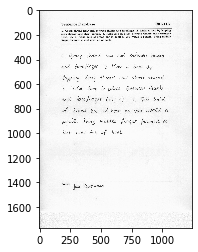

In [25]:
image = Image.open(data_path/"forms"/"e01-113.jpg")
plt.imshow(image, cmap="gray")

## Explore dataset

In [26]:
import xml.etree.ElementTree as ElementTree
from typing import Dict, List

DOWNSAMPLE_FACTOR = 2  # If images were downsampled, the regions must also be.
LINE_REGION_PADDING = 0  # add this many pixels around the exact coordinates

def get_image_file_name_from_xml_file(filename: str) -> str:
    """Get the image file name."""
    xml_root_element = ElementTree.parse(filename).getroot()  # nosec
    return xml_root_element.attrib['id'] + ".jpg"

def get_line_strings_from_xml_file(filename: str) -> List[str]:
    """Get the text content of each line. Note that we replace &quot; with "."""
    xml_root_element = ElementTree.parse(filename).getroot()  # nosec
    xml_line_elements = xml_root_element.findall('handwritten-part/line')
    return [el.attrib['text'].replace('&quot;', '"') for el in xml_line_elements]

def get_line_regions_from_xml_file(filename: str) -> List[Dict[str, int]]:
    """Get the line region dict for each line."""
    xml_root_element = ElementTree.parse(filename).getroot()  # nosec
    xml_line_elements = xml_root_element.findall('handwritten-part/line')
    return [_get_line_region_from_xml_element(el) for el in xml_line_elements]


def _get_line_region_from_xml_element(xml_line) -> Dict[str, int]:
    """
    line (xml element): has x, y, width, and height attributes
    """
    word_elements = xml_line.findall('word/cmp')
    x1s = [int(el.attrib['x']) for el in word_elements]
    y1s = [int(el.attrib['y']) for el in word_elements]
    x2s = [int(el.attrib['x']) + int(el.attrib['width']) for el in word_elements]
    y2s = [int(el.attrib['y']) + int(el.attrib['height']) for el in word_elements]
    return {
        'x1': min(x1s) // DOWNSAMPLE_FACTOR - LINE_REGION_PADDING,
        'y1': min(y1s) // DOWNSAMPLE_FACTOR - LINE_REGION_PADDING,
        'x2': max(x2s) // DOWNSAMPLE_FACTOR + LINE_REGION_PADDING,
        'y2': max(y2s) // DOWNSAMPLE_FACTOR + LINE_REGION_PADDING
    }

In [27]:
xml_files = list((data_path / "xml").glob("*.xml"))
len(xml_files)

1539

In [28]:
index = 0
xml_file_name = xml_files[index]
xml_file_name

PosixPath('/Users/mostafagazar/Work/notebooks/lines-segmentation-pytorch/data/cache/datasets/iamdb/xml/d06-050.xml')

In [29]:
xml_file_name.stem, xml_file_name.suffix

('d06-050', '.xml')

In [30]:
get_image_file_name_from_xml_file(xml_file_name)

'd06-050.jpg'

In [31]:
get_line_strings_from_xml_file(xml_file_name)

['Nor is she necessarily being deceitful. She really did feel tired',
 'until the mind got the necessary injection of a fresh - and an',
 'attractive - interest! Tiredness has, therefore, as much to do',
 'with our mental state as with our physical exhaustion. A',
 'disturbed mind can bring the healthiest body to a sense',
 'of fatigue. They wonder why they get no rest at night,',
 'even if they do sleep.']

In [32]:
get_line_regions_from_xml_file(xml_file_name)

[{'x1': 177, 'y1': 360, 'x2': 1087, 'y2': 426},
 {'x1': 169, 'y1': 450, 'x2': 1085, 'y2': 524},
 {'x1': 174, 'y1': 539, 'x2': 1065, 'y2': 592},
 {'x1': 181, 'y1': 628, 'x2': 1085, 'y2': 691},
 {'x1': 183, 'y1': 713, 'x2': 1076, 'y2': 793},
 {'x1': 185, 'y1': 804, 'x2': 1090, 'y2': 883},
 {'x1': 179, 'y1': 901, 'x2': 520, 'y2': 967}]

### Plot some images with lines overlay

In [33]:
def plot_image_with_lines_overlay(xml_file_name):
    x = Image.open(data_path/"forms"/get_image_file_name_from_xml_file(xml_file_name))
    y = get_line_regions_from_xml_file(xml_file_name)

    fig, ax = plt.subplots(1, figsize=(20, 10))
    ax.imshow(x, cmap='gray')

    for index, line in enumerate(y, 1):
        width = line['x2'] - line['x1']
        height = line['y2'] - line['y1']
        color = "red" if index % 2 == 0 else "blue"
        
        rect = patches.Rectangle(xy=(line['x1'], line['y1']), width=width, height=height, alpha=0.5, facecolor=color)
        ax.add_patch(rect)

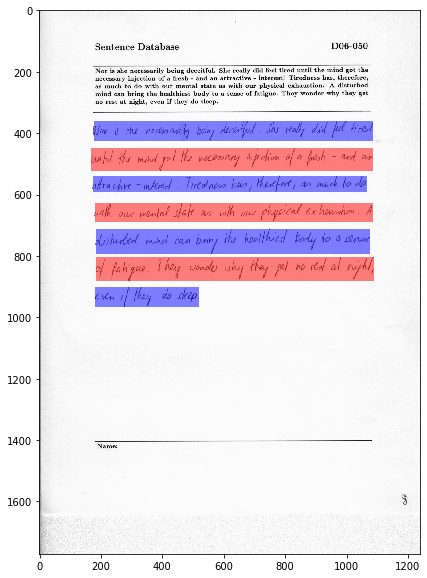

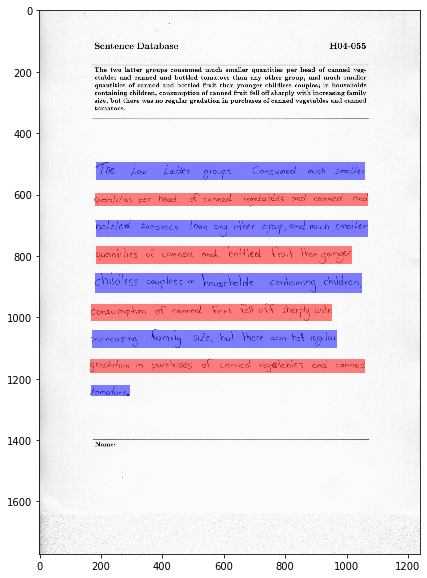

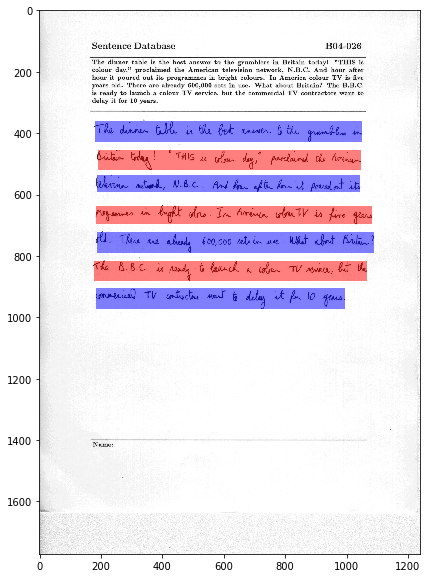

In [34]:
plot_image_with_lines_overlay(xml_files[0])
plot_image_with_lines_overlay(xml_files[1])
plot_image_with_lines_overlay(xml_files[2])